In [ ]:
import numpy as np
from tensorflow import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

Algorithm 1. Sparse similarity matching (SPASM).

In [ ]:
# Obtaining the batch of MNIST images reshaped into vectors

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
batch_size = 300
X = X_train[:batch_size].reshape(batch_size,-1).T

In [ ]:
# Step 1. Initialization of S

k = 5e-5

def Init_S(X, k):
  norm_X = np.linalg.norm(X, axis=0)
  S = X.T @ X - k * np.outer(norm_X,norm_X)
  Sum = S.sum()
  S = np.maximum(0, S)
  return S, Sum

def Init_L(X, k):
  norm_X = np.linalg.norm(X, axis=0)
  L = X.T @ X - k * np.outer(norm_X,norm_X)
  return L

S0, sum0 = Init_S(X, k)

In [ ]:
# Baseline embedding

d = 32
U, _, _ = np.linalg.svd(X)
P = U[:,:d].T @ X

In [ ]:
# Step 2. Computing L

def Iterat_ZL(S, sum, L, d):
  n0 = np.shape(S)[0]*np.shape(S)[1] - np.count_nonzero(S)

  loss = []
  for _ in range(100):

    Z = np.where(S > 0, S, np.minimum(0, L))
    sumZ = np.sum(Z)

    Z = np.where(S > 0, S, np.minimum(0, L) + 1/n0*max(0, sum-sumZ))
    
    D, Q = np.linalg.eig(Z)
    L = Q[:,:d] @ np.diag(D[:d]) @ Q[:,:d].T
    L = L.real # otherwise leaves .0 j
    loss.append(np.linalg.norm(L-Z))

  return L, loss


L0 = Init_L(P, k)
L0, loss0 = Iterat_ZL(S0, sum0, L0, d)

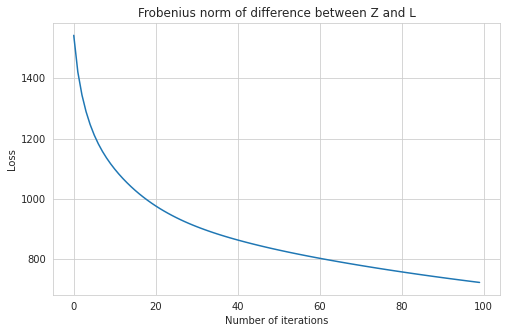

In [ ]:
plt.figure(figsize=[8,5])
plt.plot(loss0)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.title('Frobenius norm of difference between Z and L');

In [ ]:
# Step 3. Computimg G

G = np.zeros((batch_size,batch_size))

for i in range(batch_size):
  for j in range(batch_size):
    G[i,j] = L0[i,j] + k/(1-k)*(abs(L0[i,i]*L0[j,j]))**.5

In [ ]:
print('Amount of nonzeros in S divided by the total number of elements:',np.count_nonzero(S0)/(np.shape(S0)[0]*np.shape(S0)[1]))
print('rank(S) = ', np.linalg.matrix_rank(S0))
print('rank(G) = ', np.linalg.matrix_rank(G),' - got a matrix of dramatically lower rank')

Amount of nonzeros in S divided by the total number of elements: 0.07847777777777777
rank(S) =  230
rank(G) =  33  - got a matrix of dramatically lower rank


In [ ]:
# In case when the inner products are not perfectly consistent with the matrix L

Lambda, V = np.linalg.eig(G)
Y = (np.maximum(0, Lambda[:d].real))**.5 * V[:,:d].real

In [ ]:
# Evaluating the solution using Jaccard index

def get_JACCARD(X, d, k):
  S, sumS = Init_S(X, k)
  U, _, _ = np.linalg.svd(X)
  P = U[:,:d].T @ X
  L_SVD = Init_L(P, k)
  L_SPASM, _ = Iterat_ZL(S, sumS, L_SVD, d)

  ind_SPASM = np.sum(np.where((S>0)&(L_SPASM>0), 1,0))/np.sum(np.where((S>0) | (L_SPASM>0), 1,0))
  ind_SVD = np.sum(np.where((S>0)&(L_SVD>0), 1,0))/np.sum(np.where((S>0) | (L_SVD>0), 1,0))

  return ind_SPASM, ind_SVD

In [ ]:
k = 5e-5
ds = [4, 8, 16, 32, 64, 128, 256]
ind_SPASMs, ind_SVDs = [], []
for d in ds:
  ind_SPASM, ind_SVD = get_JACCARD(X, d, k)
  ind_SPASMs.append(ind_SPASM)
  ind_SVDs.append(ind_SVD)

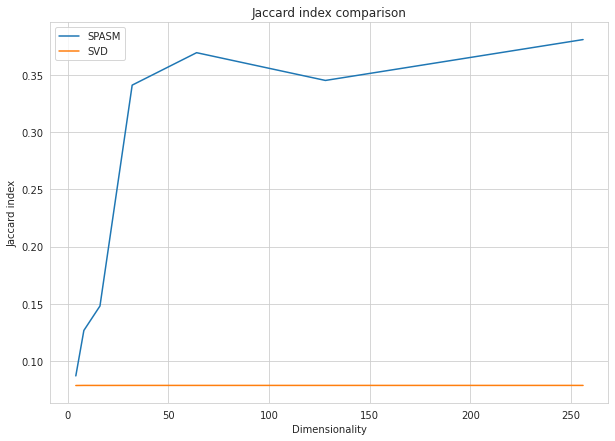

In [ ]:
plt.figure(figsize=[10,7])
plt.plot(ds, ind_SPASMs,label='SPASM')
plt.plot(ds, ind_SVDs,label='SVD')
plt.xlabel('Dimensionality')
plt.ylabel('Jaccard index')
plt.legend()
plt.title('Jaccard index comparison');

Algorithm 2. Local linear extension.

In [ ]:
# Taken from https://github.com/JAVI897/LLE-and-its-variants/blob/master/LLE/example%20LLE.ipynb
# with two corrections: 1) No weight normalization 2) cosine distances instead of the ordinary one
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import sklearn as skl
from sklearn.metrics.pairwise import cosine_distances

class LLE:
    def __init__(self, X, k_n, dim, reg = 1e-03, verbose = False, sparsity = False):
        """
        LLE object
        Parameters
        ----------
        
        X: nxd matrix
        k_n: number of neighbours
        dim: number of coordinates
        reg: regularization constant
        """
        self.X = X
        self.k_n = k_n
        self.dim = dim
        self.reg = reg if self.k_n > self.dim else 0
        self.n = self.X.shape[0]
        self.verbose = verbose
        self.sparsity = sparsity
        
    def _compute_weights(self):
        """
        Compute weights
        """
        
        # dist_matrix = pairwise_distances(self.X)
        dist_matrix = cosine_distances(self.X) # - after the authors
        # k_n nearest neighbor indices
        knn_matrix = np.argsort(dist_matrix, axis = 1)[:, 1 : self.k_n + 1]
        
        W = [] # Initialize nxn weight matrix
        for i in range(self.n):
            x_i = self.X[i]
            G = [] # Local covariance matrix
            for j in range(self.k_n):
                x_j = self.X[knn_matrix[i][j]]
                G_aux = []
                for k in range(self.k_n):
                    x_k = self.X[knn_matrix[i][k]]
                    gjk = np.dot((x_i - x_j), (x_i - x_k))
                    G_aux.append(gjk)
                G.append(G_aux)
            G = np.array(G)
            G = G + self.reg*np.eye(*G.shape) # Regularization for G
            w = np.linalg.solve(G, np.ones((self.k_n))) # Calculate weights for x_i
            # w = w / w.sum() # Normalize weights; sum(w)=1 - removed after the authors
            
            if self.verbose and i % 30 == 0:
                print('[INFO] Weights calculated for {} observations'.format(i + 1))
                
            # Create an 1xn array that will contain a 0 if x_j is not a 
            # neighbour of x_i, otherwise it will cointain the weight of x_j
            w_all = np.zeros((1, self.n))
            np.put(w_all, knn_matrix[i], w)
            W.append(list(w_all[0]))
        return np.array(W)

In [ ]:
# now we take the batch bigger and trying to embed remaining 200 vectors based on the embedding of the first 300
size = 500
X_new = X_train[:size].reshape(size,-1).T

In [ ]:
k = 30 # number of neighbours
lle = LLE(X_new.T, k, d, sparsity = True) # X.T, because it takes as an input (batch_size, ndim)
W = lle._compute_weights() 
W = W.real

In [ ]:
np.linalg.matrix_rank(W)

500

In [ ]:
m = G.shape[0] # number of landmarks
A, B, C, D = W[:W.shape[0]-m,:W.shape[0]-m], W[:W.shape[0]-m,W.shape[0]-m:], W[W.shape[0]-m:,:W.shape[0]-m], W[W.shape[0]-m:,W.shape[0]-m:]

In [ ]:
def PCG(y,A,B,C,D,om=1):
  CTAC = A.T@A + C.T@C
  # M = 1/om*(np.eye(A.shape[0]) * np.diag(CTAC) + om*np.tril(CTAC,-1)) - this preconditioner used to work once
  M = np.eye(A.shape[0])
  f = np.random.randn(C.shape[1])
  r = -(A.T@B + C.T@D) @ y - CTAC @ f
  z = np.linalg.inv(M) @ r
  p = r
  while np.linalg.norm(r) > 1e-10:
    alpha = (r.T @ z)/(p.T @ CTAC @ p)
    f = f + alpha * p
    r_prev = r
    r = r - alpha * CTAC @ p
    z_prev = z
    z = np.linalg.inv(M) @ r
    beta = (r.T @ z)/(r_prev @ z_prev)
    p = z + beta * p
  return f

In [ ]:
y_LLE = []
for i in range(20):
  y_LLE.append(PCG(G[i].T,A,B,C,D))

Here we computed 20 vectors containing the first 20 coordinates of all 200 vectors we want to reconstruct using LLE. In principle one could paralellize it and obtain remaining 764 coordinates of each vector.

Inititally we wanted to use preconditioned CG and it actually worked in one of the versions of the code, but in up to date version fails for some reason, so we left the ordinary CG.